# Image and Audio Classification

## Pretrained network image classification

In [16]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
train_df = pd.read_csv("bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("bean-leaf-lesions-classification/val.csv")

df1 = pd.concat([train_df,val_df],ignore_index = True)

df1["images"] = "bean-leaf-lesions-classification/" + df1["images"]
train_df["images"] = "bean-leaf-lesions-classification/" + train_df["images"]
val_df["images"] = "bean-leaf-lesions-classification/" + val_df["images"]

df1.shape

FileNotFoundError: [Errno 2] No such file or directory: 'bean-leaf-lesions-classification/train.csv'

In [ ]:
print(df1["category"].unique(),"\n")
print(df1["category"].value_counts())
df1.head()

train_df = df1.sample(frac = 0.7,random_state=7)
val_df = df1.drop(train_df.index)

[0 1 2] 

category
2    393
1    389
0    385
Name: count, dtype: int64


In [18]:
label_encoder = LabelEncoder()

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [19]:
class CustomImageDataset(Dataset):
    def __init__(self,dataframe,transform = None):
        self.dataframe = dataframe
        self.transform = transform if transform is not None else transforms.ToTensor()
        self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)
        
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self,idx):
        img_path = self.dataframe.iloc[idx]['images']
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        image = (image / 255).to(device)
        return image, label
    

In [20]:
train_dataset = CustomImageDataset(dataframe = train_df,transform = transform)
test_dataset = CustomImageDataset(dataframe = val_df, transform = transform)


NameError: name 'train_df' is not defined

NameError: name 'train_dataset' is not defined

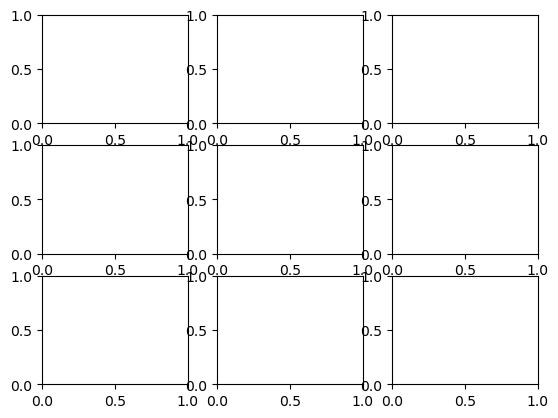

In [21]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameters
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15


In [ ]:
train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = BATCH_SIZE,shuffle = True)

In [ ]:
googlenet_model = models.googlenet(weights = 'DEFAULT')
for param in googlenet_model.parameters():
    param.requires_grad = True

In [ ]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features,len(df1["category"].unique()))
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(),LR)

NameError: name 'googlenet_model' is not defined

In [23]:
train_loss_plt, train_acc_plt = [],[]

for epoch in range(EPOCHS):
    if epoch > 8:
        BATCH_SIZE = 8
    tot_tr_acc,tot_tr_loss = 0,0
    for (inputs, labels) in train_loader:
        optimizer.zero_grad()
        outputs = googlenet_model(inputs)
        train_loss = criterion(outputs, labels)
        tot_tr_loss += train_loss.item()
        train_loss.backward()
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        tot_tr_acc += train_acc
        optimizer.step()
        
    train_loss_plt.append(round(tot_tr_loss/1000, 4))
    train_acc_plt.append(round(tot_tr_acc/(train_dataset.__len__())*100, 4))
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(tot_tr_loss/100, 4)} Train Accuracy {round((tot_tr_acc)/train_dataset.__len__() * 100, 4)}%')
    print()

NameError: name 'EPOCHS' is not defined

In [24]:
with torch.no_grad():
    tot_test_loss,tot_test_acc = 0,0
    for (inputs, labels) in test_loader:
        outputs = googlenet_model(inputs)
        test_loss = criterion(outputs, labels)
        tot_test_loss += test_loss.item()
        test_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        tot_test_acc += test_acc
print(f"Accuracy Score is: {round((tot_test_acc/test_dataset.__len__())*100, 2)}%")

NameError: name 'test_loader' is not defined

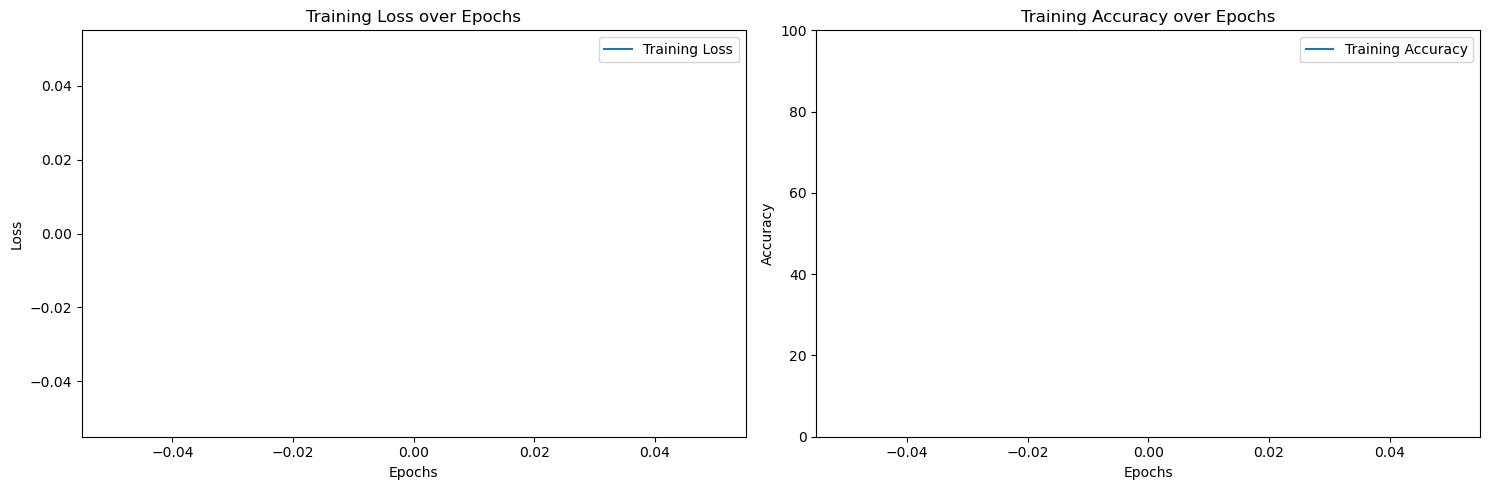

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(train_loss_plt, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(train_acc_plt, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

This model seems to be overfit

## Audio Classification

In [5]:

import torch
from torch import nn
from torch.optim import Adam
import librosa
import librosa.display
from torchvision.transforms import transforms
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"